In [11]:
import os
import copy
import tqdm
import pandas as pd
from datetime import datetime

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms, datasets, models
from torchvision.io import read_image
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


DATA_PATH = "./data/gtsrb-german-traffic-sign/"

TRAIN_FILE = "./data/gtsrb-german-traffic-sign/Train.csv"
TEST_FILE = "./data/gtsrb-german-traffic-sign/Test.csv"

TRAIN_DATA_PATH = "./data/gtsrb-german-traffic-sign/Train/"
TEST_DATA_PATH = "./data/gtsrb-german-traffic-sign/Test/"

MODEL_CHECKPOINT_PATH = './model_checkpoints/'
TENSORBOARD_PATH = './runs/'

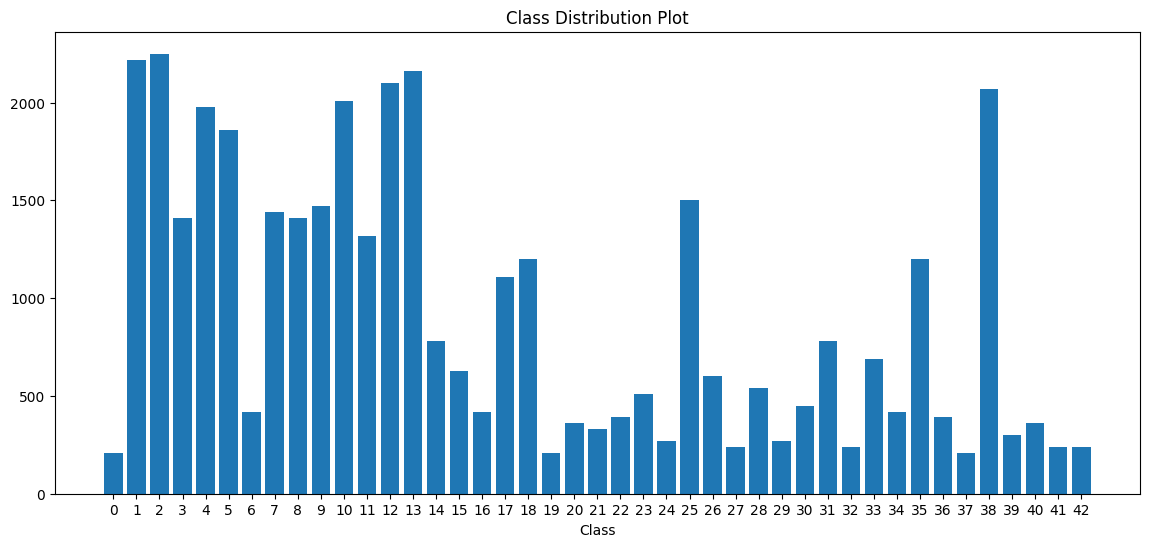

Max num samples per class: 2250
Length of dataset: 39209


In [12]:
def plot_class_distribution(df, class_name):
    _data = df.loc[:, class_name].value_counts()

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(_data.index, _data.values)
    ax.set_title('Class Distribution Plot')
    ax.set_xlabel('Class')
    ax.set_xticks(_data.index)
    ax.set_xticklabels(_data.index)
    plt.show()

    print('Max num samples per class:', _data.max())
    print('Length of dataset:', len(df))


train = pd.read_csv(TRAIN_FILE).loc[:, 'ClassId']
plot_class_distribution(train.to_frame(), 'ClassId')
del train

In [13]:
rotate_deg = 15
resize_image = 84
final_image_size = 64


transform_train = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.RandomRotation(rotate_deg),                      # Randomly rotate the image by up to 15 degrees
    # transforms.RandomHorizontalFlip(),                        # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2),                     # Randomly adjust brightness, contrast and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),       # Randomly ajust sharpness
    transforms.RandomPerspective(distortion_scale=.1, p=0.8),   # Rendomly changes the persective of the image
    transforms.RandomCrop((final_image_size, final_image_size)),# Randomly crop the image to 64x64
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), 
    transforms.CenterCrop((final_image_size, final_image_size)),# Crop the center 64x64 portion of the image
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((resize_image, resize_image)),            # Resize the image to 84x84
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2), 
    transforms.CenterCrop((final_image_size, final_image_size)),# Crop the center 64x64 portion of the image
    transforms.ToTensor(),
])

# transform_train = transforms.Compose([
#     transforms.Resize((final_image_size, final_image_size)),            # Resize the image to final size
#     transforms.AutoAugment(),
#     # transforms.TrivialAugmentWide(),
#     transforms.ToTensor(),
# ])

# transform_val = transforms.Compose([
#     transforms.Resize((final_image_size, final_image_size)),            # Resize the image to final size
#     transforms.ToTensor(),
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((final_image_size, final_image_size)),            # Resize the image to final size
#     transforms.ToTensor(),
# ])

In [14]:
class DatasetGTSRB(Dataset):
    def __init__(self, root, df, transform=None):
        self.df = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        file_path = os.path.join(self.root, self.df.iloc[index, 1])
        label = self.df.iloc[index, 0]
        image = Image.open(file_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [15]:
batch_size = 256

df = pd.read_csv(TRAIN_FILE).loc[:, ['ClassId', 'Path']]
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True)

train_dataset = DatasetGTSRB(DATA_PATH, df_train, transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = DatasetGTSRB(DATA_PATH, df_val, transform=transform_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

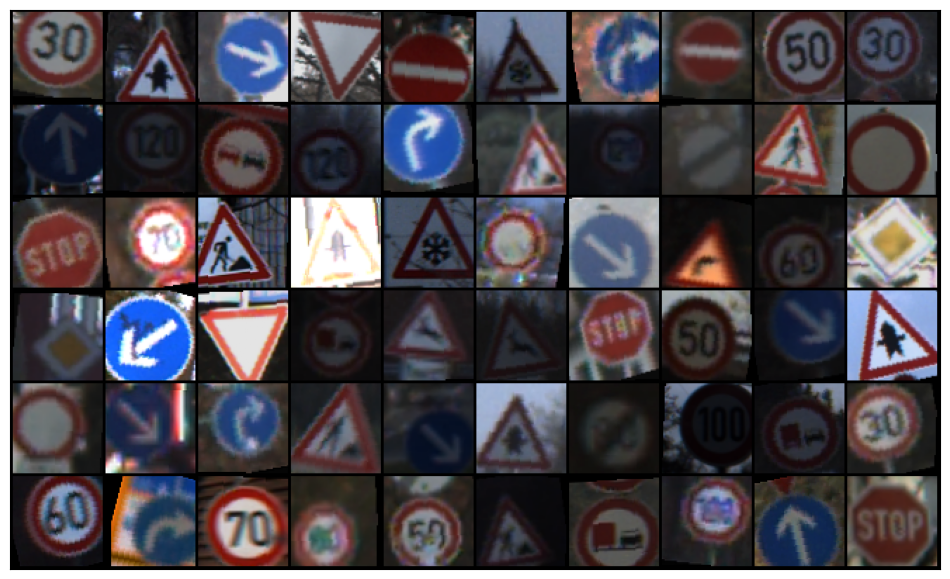

In [16]:
def show_images(dl, rows=6, cols=10):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:rows*cols], nrow=cols).permute(1, 2, 0).clamp(0,1))
        break

show_images(train_dataloader)

In [17]:
class RestNet18(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT
        self.resnet18 = models.resnet18(weights=weights, progress=False)
        n_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(n_ftrs, 43)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet18(x)

model = RestNet18()
# print(model)

In [18]:
def train_model(model, loader, optimizer, criterion, epoch, device, writer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Write the training loss and accuracy to TensorBoard
        iteration = epoch * len(loader) + i
        writer.add_scalar('Train/Loss', loss.item(), iteration)
        writer.add_scalar('Train/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [19]:
def validate_model(model, loader, epoch, device, writer):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Write the validation loss and accuracy to TensorBoard
            iteration = epoch * len(loader) + i
            writer.add_scalar('Val/Loss', loss.item(), iteration)
            writer.add_scalar('Val/Accuracy', (predicted == labels).sum().item() / labels.size(0), iteration)

    loss = running_loss / len(loader)
    acc = correct / total
    return loss, acc

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.best_model = None
        self.optimizer_state = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_model == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.delta:
            self.counter = 0
            self.best_loss = val_loss
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter} / {self.patience}"
        return False

In [21]:
# Unique identifier for the run
run = str(datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))                 

# Save path for tensorboard
writer_path = os.path.join(TENSORBOARD_PATH, f'{run}-tensorboard')
print('TensorBoard:', writer_path)

# Filename to save the model to
model_chckpoint_file = os.path.join(MODEL_CHECKPOINT_PATH, f'{run}-model.pt')

# Init the tensorboard writer
writer = SummaryWriter(writer_path)

n_epochs = 10

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Define the criterion used while training
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Common range for weight decay 1e-4 and 1e-2
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Define the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping
early_stopping = EarlyStopping(patience=5)

model.to(device)    # Load the model to the device
for epoch in range(n_epochs):

    train_loss, train_acc = train_model(model, train_dataloader, optimizer,
                                        criterion, epoch, device, writer)
    
    val_loss, val_acc = validate_model(model, val_dataloader, epoch, device, writer)
    
    # scheduler.step()  # Reduce learning rate every epoch

    es = early_stopping(model, val_loss)
    
    # Plot the epoch results
    print(f'Epoch [{epoch+1}/{n_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Early Stopping: {early_stopping.status}')
    
    # Break if early stopping true
    if es: break

writer.flush()

TensorBoard: ./runs/2023-03-04_19:19:32-tensorboard
Using device:  cpu
Epoch [1/10] | Train Loss: 1.0868 | Val Loss: 0.1258 | Train Acc: 0.7112 | Val Acc: 0.9700 | Early Stopping: 0 / 5
Epoch [2/10] | Train Loss: 0.0950 | Val Loss: 0.0340 | Train Acc: 0.9749 | Val Acc: 0.9915 | Early Stopping: 0 / 5
Epoch [3/10] | Train Loss: 0.0370 | Val Loss: 0.0182 | Train Acc: 0.9909 | Val Acc: 0.9944 | Early Stopping: 0 / 5
Epoch [4/10] | Train Loss: 0.0215 | Val Loss: 0.0104 | Train Acc: 0.9946 | Val Acc: 0.9976 | Early Stopping: 0 / 5
Epoch [5/10] | Train Loss: 0.0146 | Val Loss: 0.0116 | Train Acc: 0.9962 | Val Acc: 0.9971 | Early Stopping: 1 / 5
Epoch [6/10] | Train Loss: 0.0144 | Val Loss: 0.0123 | Train Acc: 0.9959 | Val Acc: 0.9964 | Early Stopping: 2 / 5
Epoch [7/10] | Train Loss: 0.0116 | Val Loss: 0.0072 | Train Acc: 0.9968 | Val Acc: 0.9978 | Early Stopping: 0 / 5
Epoch [8/10] | Train Loss: 0.0095 | Val Loss: 0.0079 | Train Acc: 0.9975 | Val Acc: 0.9980 | Early Stopping: 1 / 5
Epoch [9/

In [25]:
model.load_state_dict(early_stopping.best_model.state_dict())

<All keys matched successfully>

In [26]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(model_chckpoint_file))

print('Model saved at:', model_chckpoint_file)

Model saved at: ./model_checkpoints/2023-03-04_19:19:32-model.pt


In [27]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(loader)
    acc = correct / total

    print(f'Test Loss: {loss:.4f} | Test Acc: {acc:.4f}')

In [30]:

# Load test dataset
df_test = pd.read_csv(TEST_FILE).loc[:, ['ClassId', 'Path']]

test_dataset = DatasetGTSRB(DATA_PATH, df_test, transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

# Loading a saved model
checkpoint = torch.load(model_chckpoint_file)
# checkpoint = torch.load(os.path.join('./model_checkpoints', '2023-03-01_18:52:41-model.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Evaluate the model
evaluate_model(model, test_dataloader, criterion, device)

Using device:  cpu
Test Loss: 0.0630 | Test Acc: 0.9827
